In [1]:
'''
Usage:
1. Data directory must be in the same directory as the script
2. Images, lables and superpixels directories must be inside data directory
3. Script parameters must be specified in script parameters cell
'''

'\nUsage:\n1. Data directory must be in the same directory as the script\n2. Images, lables and superpixels directories must be inside data directory\n3. Script parameters must be specified in script parameters cell\n'

In [1]:
import numpy as np
import os
import collections
import matplotlib.pyplot as plt
import skimage.future.graph as skigraph
import shutil
import pickle
import keras
import tensorflow as tf
import networkx as nx
import time
import sys

from kgcnn.literature.GCN import make_model
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from kgcnn.utils.learning import LinearLearningRateScheduler
from PIL import Image, ImageOps
from radiomics import featureextractor
import numpy.ma as ma
import nrrd
import warnings

In [2]:
# config

# script parameterss
MAIN_DIR_PATH = "/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint"
DATA_DIR_NAME = "input/data_set_2"
IMAGES_DIR_NAME = "images"
SUPERPIXELS_LABELS_DIR_NAME = "labels"
SUPERPIXELS_DIR_NAME = "superpixels"
MASKS_DIR_NAME = "masks"

IMAGE_FILE_PREFIX = "STIR"
SUPERPIXELS_FILE_PREFIX = "1000SuperPixelMeanValueTPS_"

IMG_CMAP = "pink"
EDGE_CMAP = "viridis"
EDGE_WIDTH = 2

CREATE_SUPERPIXELS_IMAGES = False

# globals
DATA_DIR_PATH = f"{MAIN_DIR_PATH}/{DATA_DIR_NAME}"
IMAGES_DIR_PATH = f"{DATA_DIR_PATH}/{IMAGES_DIR_NAME}"
SUPERPIXELS_LABELS_DIR_PATH = f"{DATA_DIR_PATH}/{SUPERPIXELS_LABELS_DIR_NAME}"
SUPERPIXELS_DIR_PATH = f"{DATA_DIR_PATH}/{SUPERPIXELS_DIR_NAME}"
MASKS_DIR_PATH = f"{DATA_DIR_PATH}/{MASKS_DIR_NAME}"
subgraphs_info = []

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)

In [25]:
# utils
def show_2d_image_from_3d_image(image_3d, index_of_2d_image):
    plt.figure(figsize = (20,20))
    plt.imshow(image_3d[:,:,index_of_2d_image], cmap='gray')
    plt.show()
    
def save_object(filename, obj):
    obj_file = open(filename, 'wb')
    pickle.dump(obj, obj_file)
    obj_file.close()
    
def load_object(filename):
    obj_file = open(filename, 'rb')
    obj = pickle.load(obj_file)
    obj_file.close()
    
    return obj

# read data
def read_binary_data_3D(file_name, image_size, image_count, voxel_bytes, signed='Y', byte_order='BE'):
    if voxel_bytes == 2:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint16)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int16)
    elif voxel_bytes == 1:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint8)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int8)
    else:
        print('Wrong number of bytes per voxel')
        return

    f = open(file_name, "rb")
    for i in range(0, image_count):
        for j in range(0, image_size):
            for k in range(0, image_size):
                byte = f.read(voxel_bytes)
                if voxel_bytes == 2:
                    if byte_order == 'BE':
                        a = 256 * byte[0] + byte[1]
                    else:
                        a = byte[0] + 256 * byte[1]
                else:
                    a = byte[0]
                d[j,k,i] = a
    f.close()
    return d

# rag creation
FileInfo = collections.namedtuple('FileInfo', ['name', 'patient_id', 'height', 'width', 'image_count', 'voxel_bytes'])


class Rag:
    def __init__(self, rag, superpixels_labels, file_id):
        self.rag = rag
        self.superpixels_labels = superpixels_labels
        self.file_id = file_id

class Subgraph:
    def __init__(self, rag, superpixel_label, neighbor_graph, label):
        self.rag = rag
        self.superpixel_label = superpixel_label
        self.neighbor_graph = neighbor_graph
        self.label = label
        self.unnormalized_edge_indices = None
        self.normalized_edge_indices = None
        self.edges = None
        self.nodes = None
        
def create_rag_on_superpixels_image(superpixel_labels, superpixels, rag, file_info, image_number, edge_width, img_cmap, edge_cmap):
    PATIENT_ID_DIR_PATH = f"saved_objects/rags/{file_info.patient_id}"
    RAG_IMAGE_PATH = f"{PATIENT_ID_DIR_PATH}/rag_{image_number}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.png"
    if os.path.exists(RAG_IMAGE_PATH):
        shutil.rmtree(PATIENT_ID_DIR_PATH)
    os.makedirs(PATIENT_ID_DIR_PATH, exist_ok=True)
    
    rag_file = open(RAG_IMAGE_PATH, "w")
    rag_file.close()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    ax.axis('off')
    lc = skigraph.show_rag(
        superpixel_labels, rag, superpixels, img_cmap=img_cmap, edge_width=edge_width, edge_cmap=edge_cmap, ax=ax
    )
    fig.colorbar(lc, fraction=0.04, ax=ax)
    fig.savefig(RAG_IMAGE_PATH)
    plt.close(fig) 
    
def assign_label(mask, superpixels_labels, rag, image):
    white_pixels_count = {}
    total_pixels_count = {}
    for (i, row) in enumerate(superpixels_labels):
        for (j, label) in enumerate(row):
            if label in total_pixels_count:
                total_pixels_count[label] += 1
            else:
                total_pixels_count[label] = 1 
            if mask[i][j] == 1:
                if label in white_pixels_count:
                    white_pixels_count[label] += 1
                else:
                    white_pixels_count[label] = 1
                    
    for (i, node) in enumerate(rag):
        if i in white_pixels_count and white_pixels_count[i] / total_pixels_count[i] >= 0.6:
            rag.nodes[node]['label'] = '1'
        else:
            rag.nodes[node]['label'] = '0'
            
            
    # assign radiomics features
    labels = np.unique(superpixels_labels)
    for label in labels:
        mask = (superpixels_labels == label).astype(int)
        #mx = ma.masked_array(image, mask=np.where((mask==0)|(mask==1), mask^1, mask))
        nrrd.write(f"{label}_image.nrrd", image)
        nrrd.write(f"{label}_label.nrrd", mask)
        imagePath = os.path.join(MAIN_DIR_PATH, str(label) + "_image.nrrd")
        labelPath = os.path.join(MAIN_DIR_PATH, str(label) + "_label.nrrd")
        extractor = featureextractor.RadiomicsFeatureExtractor()
        try:             
            result = extractor.execute(imagePath, labelPath)
        except:
            print(mask)
            print(label)
            print("FAILED")
            nrrd.write(f"FAILED_{label}_label.nrrd", mask)
                
        rag.nodes[label]['original_glszm_GrayLevelNonUniformity'] = result['original_glszm_GrayLevelNonUniformity']
        rag.nodes[label]['original_glszm_GrayLevelVariance'] = result['original_firstorder_RobustMeanAbsoluteDeviation']
        rag.nodes[label]['original_glszm_HighGrayLevelZoneEmphasis'] = result['original_glszm_HighGrayLevelZoneEmphasis']
        rag.nodes[label]['original_glszm_LargeAreaEmphasis'] = result['original_glszm_LargeAreaEmphasis']
        rag.nodes[label]['original_glszm_SmallAreaEmphasis'] = result['original_glszm_SmallAreaEmphasis']
        rag.nodes[label]['original_glszm_ZoneVariance'] = result['original_glszm_ZoneVariance']
        rag.nodes[label]['original_glszm_SizeZoneNonUniformityNormalized'] = result['original_glszm_SizeZoneNonUniformityNormalized']
        rag.nodes[label]['original_glszm_ZonePercentage'] = result['original_glszm_ZonePercentage']
        rag.nodes[label]['original_glszm_SmallAreaLowGrayLevelEmphasis'] = result['original_glszm_SmallAreaLowGrayLevelEmphasis']
        rag.nodes[label]['original_glszm_SmallAreaHighGrayLevelEmphasis'] = result['original_glszm_SmallAreaHighGrayLevelEmphasis']        
        rag.nodes[label]['original_glszm_ZoneEntropy'] = result['original_glszm_ZoneEntropy']
        rag.nodes[label]['original_glszm_SizeZoneNonUniformity'] = result['original_glszm_SizeZoneNonUniformity']
    
def process_bmp_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path, masks_dir_path):
    file_names = os.listdir(images_dir_path)
    rags = []
    
    for (image_index, file_name) in enumerate(file_names):
        print(f"Processing file: {image_index + 1}/{len(file_names)}")
        img = ImageOps.grayscale((Image.open(f"{IMAGES_DIR_PATH}/{file_name}")))
        img = np.array(img)
        img = img/(img.max()/255.0)  
        file_id = file_name.split("_")[-1][0:-4]
        mask = np.array(ImageOps.grayscale(Image.open(f"{masks_dir_path}/mask_{file_id}.bmp")))
        try:
            superpixels_labels = np.fromfile(f"{superpixels_labels_dir_path}/org_{file_id}.dat", dtype=np.dtype((np.int32, (img.shape[0], img.shape[1]))))[0]
        except: 
            continue
        rag = skigraph.rag_mean_color(img, superpixels_labels)
        rags.append(Rag(rag, superpixels_labels, file_id))
        assign_label(mask, superpixels_labels, rag, img)
        im_mask = Image.fromarray((mask*255).astype(np.uint8))
        im_mask.save(f"segmentations/{file_id}.png")
    print("All files have been processed")
    
    return rags



# split into subgraphs containing node and node neighbors
def split_into_subgraphs(rags):
    subgraphs = []
    for rag in rags:
        for (i, node) in enumerate(rag.rag.nodes):
            nodes = [n for n in rag.rag.neighbors(node)]
            nodes.append(node)
            neighbor_graph = rag.rag.subgraph(nodes)
            label = [float(rag.rag.nodes[node]['label'])]
            subgraphs.append(Subgraph(rag, i, neighbor_graph, label))
    return subgraphs

def normalize_edge_indices(edge_indices):
    result = []
    flat_list = []
    for sublist in edge_indices:
        for item in sublist:
            flat_list.append(item)
            
    flat_list.sort()
    flat_list = list(dict.fromkeys(flat_list))
    change = {key:value for (value, key) in enumerate(flat_list)}
    
    for sublist in edge_indices:
        temp = []
        for item in sublist:
            temp.append(change[item])
        result.append(temp)    
    
    
    return result

def prepare_data(neighbor_graphs):
    nodes = []
    edge_indices = []
    edges = []
    for (subgraph, graph) in enumerate(neighbor_graphs):
        mean_intensities = []
        edges_prim = []
        for node in graph.nodes:
            mean_intensities.append(graph.nodes[node]['mean color'][0])  
        for data in graph.edges.data():
            edges_prim.append(1)
        nodes.append(mean_intensities)
        edges.append(edges_prim)
        edge_indices.append(normalize_edge_indices([list(e) for e in graph.edges]))
        #subgraphs_info[subgraph].nodes = nodes[-1]
        #subgraphs_info[subgraph].unnormalized_edge_indices = [list(e) for e in graph.edges]
        #subgraphs_info[subgraph].normalized_edge_indices = edge_indices[-1]
        #subgraphs_info[subgraph].edges = edges[-1]

    return nodes, edge_indices, edges

def process_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path, masks_dir_path, file_format):
    if file_format == 'raw':
        return process_all_3D_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path)
    elif file_format == 'bmp':
        return process_bmp_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path, masks_dir_path)



In [ ]:
import logging
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

rags = process_images(IMAGES_DIR_PATH, SUPERPIXELS_LABELS_DIR_PATH, SUPERPIXELS_DIR_PATH, MASKS_DIR_PATH, 'bmp')

Processing file: 1/140
Processing file: 2/140
Processing file: 3/140
Processing file: 4/140
Processing file: 5/140
Processing file: 6/140
Processing file: 7/140
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Processing file: 8/140
Processing file: 9/140
Processing file: 10/140
Processing file: 11/140
Processing file: 12/140
Processing file: 13/140
Processing file: 14/140
Processing file: 15/140
Processing file: 16/140
Processing file: 17/140
Processing file: 18/140
Processing file: 19/140
Processing file: 20/140
Processing file: 21/140
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Processing file: 22/140
Processing file: 23/140
Processing file: 24/140
Processing file: 25/140
Processing file: 26/140
Processing file: 27/140
Processing file: 28/140
Processing file: 29/140
Processing file: 30/140
Processing file: 31/140
Processing file: 32/140
Processing file: 33/140
Processing file: 34/140
Processing file: 35/140
Processing file: 36/140
Processing file: 37/140
Processing file: 38/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


Processing file: 39/140
Processing file: 40/140
Processing file: 41/140
Processing file: 42/140
Processing file: 43/140
Processing file: 44/140


In [4]:
rags = load_object('saved_objects/rags')

In [5]:
rags_train, rags_test = train_test_split(rags, train_size=0.8, random_state=1)

In [9]:
subgraphs_train = split_into_subgraphs(rags_train)
subgraphs_test = split_into_subgraphs(rags_test)

neighbor_graphs_train = []
neighbor_graphs_test = []
labels_train = []
labels_test = []

for subgraph_train in subgraphs_train:
    neighbor_graphs_train.append(subgraph_train.neighbor_graph)
    labels_train.append(subgraph_train.label)
    
for subgraph_test in subgraphs_test:
    neighbor_graphs_test.append(subgraph_test.neighbor_graph)
    labels_test.append(subgraph_test.label)

In [10]:
nodes_train, edge_indices_train, edges_train =  prepare_data(neighbor_graphs_train)
nodes_test, edge_indices_test, edges_test =  prepare_data(neighbor_graphs_test)

In [8]:
print(subgraphs_info[20].unnormalized_edge_indices)

[[1, 18], [1, 20], [1, 25], [33, 18], [33, 20], [33, 37], [37, 20], [37, 25], [18, 20], [20, 25]]


In [11]:
for i in range(len(labels_train)):
    edges_train[i] = np.expand_dims(edges_train[i], axis=-1).astype(np.float32)
    nodes_train[i] =np.expand_dims(nodes_train[i],axis=-1).astype(np.int)
    
for i in range(len(labels_test)):
    edges_test[i] = np.expand_dims(edges_test[i], axis=-1).astype(np.float32)
    nodes_test[i] = np.expand_dims(nodes_test[i],axis=-1).astype(np.int)
    
nodes_train = ragged_tensor_from_nested_numpy(nodes_train)
edges_train = ragged_tensor_from_nested_numpy(edges_train)
edge_indices_train = ragged_tensor_from_nested_numpy(edge_indices_train)

nodes_test = ragged_tensor_from_nested_numpy(nodes_test)
edges_test = ragged_tensor_from_nested_numpy(edges_test)
edge_indices_test = ragged_tensor_from_nested_numpy(edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.array(labels_train)
ytest = np.array(labels_test)

INFO:kgcnn: Updated model kwargs:
{'depth': 3,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'float32',
             'name': 'edge_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'int64',
             'name': 'edge_indices',
             'ragged': True,
             'shape': (None, 2)}],
 'name': 'Unet',
 'output_embedding': 'graph',
 'output_mlp': {'activation': ['relu', 'relu', 'sigmoid'],
                'units': [140, 70, 1],
                '

/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_attributes (InputLayer)    [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 64)     128         node_attributes[0][0]            
__________________________________________________________________________________________________
edge_attributes (InputLayer)    [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
edge_indices (InputLayer)       [(None, None, 2)]    0                                            
______________________________________________________________________________________________

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Ten

833/833 - 4s - loss: 0.5015 - accuracy: 0.7824
Epoch 2/150
833/833 - 2s - loss: 0.4222 - accuracy: 0.8070
Epoch 3/150
833/833 - 2s - loss: 0.3834 - accuracy: 0.8350
Epoch 4/150
833/833 - 2s - loss: 0.3551 - accuracy: 0.8570
Epoch 5/150
833/833 - 2s - loss: 0.3443 - accuracy: 0.8612
Epoch 6/150
833/833 - 2s - loss: 0.3381 - accuracy: 0.8640
Epoch 7/150
833/833 - 2s - loss: 0.3316 - accuracy: 0.8679
Epoch 8/150
833/833 - 2s - loss: 0.3320 - accuracy: 0.8667
Epoch 9/150
833/833 - 2s - loss: 0.3299 - accuracy: 0.8684
Epoch 10/150
833/833 - 3s - loss: 0.3278 - accuracy: 0.8680 - val_loss: 0.3425 - val_accuracy: 0.8688
Epoch 11/150
833/833 - 2s - loss: 0.3244 - accuracy: 0.8691
Epoch 12/150
833/833 - 2s - loss: 0.3253 - accuracy: 0.8668
Epoch 13/150
833/833 - 2s - loss: 0.3247 - accuracy: 0.8678
Epoch 14/150
833/833 - 2s - loss: 0.3186 - accuracy: 0.8711
Epoch 15/150
833/833 - 2s - loss: 0.3205 - accuracy: 0.8684
Epoch 16/150
833/833 - 2s - loss: 0.3167 - accuracy: 0.8726
Epoch 17/150
833/83

833/833 - 3s - loss: 0.2858 - accuracy: 0.8814
Epoch 130/150
833/833 - 4s - loss: 0.2857 - accuracy: 0.8797 - val_loss: 0.3003 - val_accuracy: 0.8793
Epoch 131/150
833/833 - 3s - loss: 0.2851 - accuracy: 0.8801
Epoch 132/150
833/833 - 3s - loss: 0.2851 - accuracy: 0.8812
Epoch 133/150
833/833 - 3s - loss: 0.2860 - accuracy: 0.8804
Epoch 134/150
833/833 - 3s - loss: 0.2835 - accuracy: 0.8813
Epoch 135/150
833/833 - 3s - loss: 0.2836 - accuracy: 0.8803
Epoch 136/150
833/833 - 4s - loss: 0.2835 - accuracy: 0.8819
Epoch 137/150
833/833 - 3s - loss: 0.2835 - accuracy: 0.8809
Epoch 138/150
833/833 - 3s - loss: 0.2827 - accuracy: 0.8806
Epoch 139/150
833/833 - 3s - loss: 0.2814 - accuracy: 0.8819
Epoch 140/150
833/833 - 3s - loss: 0.2819 - accuracy: 0.8817 - val_loss: 0.2959 - val_accuracy: 0.8806
Epoch 141/150
833/833 - 3s - loss: 0.2809 - accuracy: 0.8812
Epoch 142/150
833/833 - 3s - loss: 0.2800 - accuracy: 0.8819
Epoch 143/150
833/833 - 4s - loss: 0.2801 - accuracy: 0.8825
Epoch 144/150
8

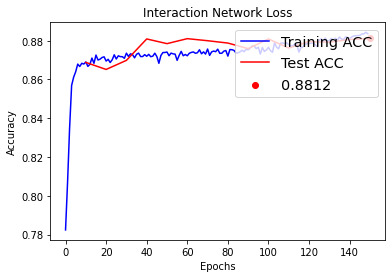

In [12]:
model = make_model(
    name = "Unet",
    inputs = [{'shape': (None, 1), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
    input_embedding = {"node": {"input_dim": 55, "output_dim": 64},
                       "edge": {"input_dim": 10, "output_dim": 64}},

    output_embedding =  'graph',
    output_mlp = {"use_bias": [True, True, False], "units": [140, 70, 1],
                "activation": ['relu', 'relu', 'sigmoid']},
    gcn_args = {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean', 
                "normalize_by_weights": False},
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

In [13]:
probability = model.predict(xtest)
predictions = np.round(probability)
comparison = np.concatenate((predictions, ytest, probability), axis=1)
# print(comparison)

hole = 0
true = 0
false = 0
hole2 = 0
true2 = 0
false2 = 0
for value in comparison:
    if value[1] == 1.:
        hole += 1
        if value[0] == 0.:
            false +=1
        else:
            true +=1
    if value[1] == 0.:
        hole2 += 1
        if value[0] == 1.:
            false2 +=1
        else:
            true2 +=1
print(f"{true}/{hole}")
print(f"{false}/{hole}")
print(f"{true2}/{hole2}")
print(f"{false2}/{hole2}")

1121/1531
410/1531
4703/5078
375/5078


In [22]:
predicted_images = {}

for (i, subgraph) in enumerate(subgraphs_test):
    if subgraph.rag.file_id not in predicted_images:
        predicted_images[subgraph.rag.file_id] = np.copy(subgraph.rag.superpixels_labels)
    predicted_images[subgraph.rag.file_id][ predicted_images[subgraph.rag.file_id] == subgraph.superpixel_label] = predictions[i] - 2

for key in predicted_images.keys():
    predicted_images[key][predicted_images[key] == -1] = 1
    predicted_images[key][predicted_images[key] == -2] = 0
    predicted_images[key]=predicted_images[key]*255
    im = Image.fromarray(predicted_images[key].astype(np.uint8))
    print( predicted_images[key])
    im.save(f"predictions/{key}.png")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  

[[  0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255 255 255
  255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255 255 255
  255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  

In [12]:
save_object('saved_objects/rags', rags)
save_object('saved_objects/neighbor_graphs', neighbor_graphs)
save_object('saved_objects/labels', labels)
save_object('saved_objects/nodes', nodes)
save_object('saved_objects/edges', edges)
save_object('saved_objects/edge_indices', edge_indices)
model.save('/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/saved_objects')

INFO:tensorflow:Assets written to: /home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/saved_objects/assets


INFO:tensorflow:Assets written to: /home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/saved_objects/assets


In [13]:
rags = load_object('saved_objects/rags')
neighbor_graphs = load_object('saved_objects/neighbor_graphs')
nodes = load_object('saved_objects/nodes')
edges = load_object('saved_objects/edges')
edge_indices = load_object('saved_objects/edge_indices')
labels = load_object('saved_objects/labels')
model = keras.models.load_model('/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/saved_objects')